In [1]:
# !pip install koalas

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
import os
import pandas as pd
import numpy as np
import sys
# import databricks.koalas as ks

In [4]:
# # df=ks.read_csv("animals_comments.csv")
# # df.head(10)
# # df.columns = ['creator_name','userid', 'comment']
# df = pd.read_csv("animals_comments.csv")
# df.columns = ["creator_name","userid","comment"]
# df.head()
# df.to_csv("animals_comments.csv")

In [5]:
# df.shape

In [6]:
# sys.setrecursionlimit(300000)

In [7]:
df_clean = spark.read.csv("animals_comments.csv",header=True)
df_clean.show(10)
df_clean.printSchema()

+---+--------------------+------+-------------------------------------+
|_c0|        creator_name|userid|                              comment|
+---+--------------------+------+-------------------------------------+
|  0|        Doug The Pug|  87.0|                 I shared this to ...|
|  1|        Doug The Pug|  87.0|                   Super cute  😀🐕🐶|
|  2|         bulletproof| 530.0|                 stop saying get e...|
|  3|       Meu Zoológico| 670.0|                 Tenho uma jiboia ...|
|  4|              ojatro|1031.0|                 I wanna see what ...|
|  5|     Tingle Triggers|1212.0|                 Well shit now Im ...|
|  6|Hope For Paws - O...|1806.0|                 when I saw the en...|
|  7|Hope For Paws - O...|2036.0|                 Holy crap. That i...|
|  8|          Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
|  9|       Brian Barczyk|2698.0|                 Call the teddy Larry|
+---+--------------------+------+-------------------------------------+
only showing

In [8]:
df_clean.count() 

5820036

# Label the data

In [9]:
# # find user with preference of dog and cat
# searchfor = ['my dog', 'I have a dog', 'my dogs', 'I have dog', 'my cat', 'my cats', 'I have a cat', 'I have cat', 'my puppy', 'my puppies', 'my kitty', 'my kitties', 'I have a kitty', 'I have kitties', 'I have a puppy', 'I have puppies']
# df['dog_cat'] = df['comment'].str.contains('|'.join(searchfor))
# df['no_pet'] = ~df["comment"].str.contains('my|have')
                  
# df.head(10)
# # print(df.shape)

In [10]:
# df['comment'] = df['comment'].astype(str).apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

In [11]:
# df.head(10)

In [12]:
# df["bool_Comments"] = df['comment'].str.contains(pat = '\w')
# df.head(10)

In [13]:
# df = df.loc[df["bool_Comments"]]
# df = df.drop("bool_Comments", axis = 1)

In [14]:
# spark_df = df.to_spark()

In [15]:
# find user with preference of dog and cat
from pyspark.sql.functions import when
from pyspark.sql.functions import col

# you can user your ways to extract the label
#'my dog', 'I have a dog', 'my dogs', 'I have dog', 'my cat', 'my cats', 
#'I have a cat', 'I have cat', 'my puppy', 'my puppies', 'my kitty', 'my kitties', 
#'I have a kitty', 'I have kitties', 'I have a puppy', 'I have puppies'

df_clean = df_clean.withColumn("dog_cat", \
                           (when(col("comment").like("%my dog%"), 1) \
                           .when(col("comment").like("%I have a dog%"), 1) \
                           .when(col("comment").like("%I have dog%"), 1) \
                           .when(col("comment").like("%my cat%"), 1) \
                           .when(col("comment").like("%I have a cat%"), 1) \
                           .when(col("comment").like("%I have cat%"), 1) \
                           .when(col("comment").like("%my puppy%"), 1) \
                           .when(col("comment").like("%my puppies%"), 1) \
                           .when(col("comment").like("%my kitty%"), 1) \
                           .when(col("comment").like("%my kitties%"), 1) \
                           .when(col("comment").like("%I have a kitty%"), 1) \
                           .when(col("comment").like("%I have kitties%"), 1) \
                           .when(col("comment").like("%I have a puppy%"), 1) \
                           .when(col("comment").like("%I have puppies%"), 1) \
                           .when(col("comment").like("%my pussy%"), 1) \
                           .otherwise(0)))
df_clean = df_clean.withColumn("no_pet", \
                           (when(col("comment").like("%my%"), 0) \
                           .when(col("comment").like("%have%"), 0) \
                           .otherwise(1)))
df_clean.show(10)

+---+--------------------+------+-------------------------------------+-------+------+
|_c0|        creator_name|userid|                              comment|dog_cat|no_pet|
+---+--------------------+------+-------------------------------------+-------+------+
|  0|        Doug The Pug|  87.0|                 I shared this to ...|      0|     0|
|  1|        Doug The Pug|  87.0|                   Super cute  😀🐕🐶|      0|     1|
|  2|         bulletproof| 530.0|                 stop saying get e...|      0|     0|
|  3|       Meu Zoológico| 670.0|                 Tenho uma jiboia ...|      0|     1|
|  4|              ojatro|1031.0|                 I wanna see what ...|      0|     1|
|  5|     Tingle Triggers|1212.0|                 Well shit now Im ...|      0|     1|
|  6|Hope For Paws - O...|1806.0|                 when I saw the en...|      0|     1|
|  7|Hope For Paws - O...|2036.0|                 Holy crap. That i...|      0|     1|
|  8|          Life Story|2637.0|武器はクエストで貰えるんじ

In [16]:
from pyspark.sql.functions import rand 

df_clean.orderBy(rand(seed=0)).createOrReplaceTempView("table1")
df_clean = spark.sql("select * from table1 limit 10000")

In [17]:
# df_clean = df_clean.repartition(100)
# df_clean.rdd.getNumPartitions()

In [18]:
from pyspark.ml.feature import StopWordsRemover

# Define a list of stop words or use default list
remover = StopWordsRemover()
stopwords = remover.getStopWords() 

# Display some of the stop words
stopwords[:10]
Out[196]: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [19]:
# data preprocessing 
from pyspark.ml.feature import RegexTokenizer

regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="text", pattern="\\W")
df_clean = regexTokenizer.transform(df_clean)
df_clean.show(10)

+-------+-----------------------+---------+--------------------+-------+------+--------------------+
|    _c0|           creator_name|   userid|             comment|dog_cat|no_pet|                text|
+-------+-----------------------+---------+--------------------+-------+------+--------------------+
|5172407|     Taylor Nicole Dean|1017798.0|i find it funny c...|      0|     0|[i, find, it, fun...|
|1139499|         LightningLpsTV|2383838.0|I dare Dakota to ...|      0|     1|[i, dare, dakota,...|
|3556124|   Cincinnati Zoo & ...|2145416.0|He is so gentle w...|      0|     1|[he, is, so, gent...|
|  49138|        Einstein Parrot| 585165.0|Einstein youre so...|      0|     1|[einstein, youre,...|
|2008117|          Brian Barczyk|1642854.0|Brian is my favou...|      0|     0|[brian, is, my, f...|
|4433171|   Hope For Paws - O...|2201609.0|I would Of Adopte...|      0|     0|[i, would, of, ad...|
|1800552|               The Dodo|2299570.0|    I started crying|      0|     1|[i, started,

In [20]:
# # remove empty text vector
# import pyspark.sql.functions as F
# df_clean = df_clean.withColumn("size", F.size(F.col('text')))
# df_clean = df_clean.select(['creator_name', 'userid', 'comment', 'text', 'dog_cat','no_pet']).where(df_clean.size != 0)
# df_clean.show(10)

In [21]:
remover.setInputCol("text")
remover.setOutputCol("vector_no_stopw")
df_clean = remover.transform(df_clean)
df_clean.show(10) 

+-------+-----------------------+---------+--------------------+-------+------+--------------------+--------------------+
|    _c0|           creator_name|   userid|             comment|dog_cat|no_pet|                text|     vector_no_stopw|
+-------+-----------------------+---------+--------------------+-------+------+--------------------+--------------------+
|5172407|     Taylor Nicole Dean|1017798.0|i find it funny c...|      0|     0|[i, find, it, fun...|[find, funny, cau...|
|1139499|         LightningLpsTV|2383838.0|I dare Dakota to ...|      0|     1|[i, dare, dakota,...|[dare, dakota, pr...|
|3556124|   Cincinnati Zoo & ...|2145416.0|He is so gentle w...|      0|     1|[he, is, so, gent...|[gentle, enormous...|
|  49138|        Einstein Parrot| 585165.0|Einstein youre so...|      0|     1|[einstein, youre,...|[einstein, youre,...|
|2008117|          Brian Barczyk|1642854.0|Brian is my favou...|      0|     0|[brian, is, my, f...|[brian, favourite...|
|4433171|   Hope For Paw

In [22]:
from nltk.stem.porter import *
from pyspark.sql.functions import udf

# Instantiate stemmer object
stemmer = PorterStemmer()

# Create stemmer python function
def stem(in_vec):
    out_vec = []
    for t in in_vec:
        t_stem = stemmer.stem(t)
        if len(t_stem) > 2:
            out_vec.append(t_stem)       
    return out_vec

# Create user defined function for stemming with return type Array<String>
from pyspark.sql.types import *
stemmer_udf = udf(lambda x: stem(x), ArrayType(StringType()))

# Create new column with vectors containing the stemmed tokens 
df_clean = df_clean.withColumn("vector_stemmed", stemmer_udf("vector_no_stopw"))

df_clean.show(10)

+-------+-----------------------+---------+--------------------+-------+------+--------------------+--------------------+--------------------+
|    _c0|           creator_name|   userid|             comment|dog_cat|no_pet|                text|     vector_no_stopw|      vector_stemmed|
+-------+-----------------------+---------+--------------------+-------+------+--------------------+--------------------+--------------------+
|5172407|     Taylor Nicole Dean|1017798.0|i find it funny c...|      0|     0|[i, find, it, fun...|[find, funny, cau...|[find, funni, cau...|
|1139499|         LightningLpsTV|2383838.0|I dare Dakota to ...|      0|     1|[i, dare, dakota,...|[dare, dakota, pr...|[dare, dakota, pr...|
|3556124|   Cincinnati Zoo & ...|2145416.0|He is so gentle w...|      0|     1|[he, is, so, gent...|[gentle, enormous...|[gentl, enorm, sn...|
|  49138|        Einstein Parrot| 585165.0|Einstein youre so...|      0|     1|[einstein, youre,...|[einstein, youre,...|[einstein, your, ...|

In [23]:
# use word2vec get text vector feature.
from pyspark.ml.feature import Word2Vec
# Learn a mapping from words to Vectors. (choose higher vectorSize here)
#word2Vec = Word2Vec(vectorSize=20, minCount=1, inputCol="text", outputCol="wordVector")
word2Vec = Word2Vec(vectorSize=20, minCount=1, inputCol="vector_stemmed", outputCol="wordVector")
model = word2Vec.fit(df_clean)

df_model = model.transform(df_clean)
df_model.show(10)

+-------+-----------------------+---------+--------------------+-------+------+--------------------+--------------------+--------------------+--------------------+
|    _c0|           creator_name|   userid|             comment|dog_cat|no_pet|                text|     vector_no_stopw|      vector_stemmed|          wordVector|
+-------+-----------------------+---------+--------------------+-------+------+--------------------+--------------------+--------------------+--------------------+
|5172407|     Taylor Nicole Dean|1017798.0|i find it funny c...|      0|     0|[i, find, it, fun...|[find, funny, cau...|[find, funni, cau...|[0.06860379758290...|
|1139499|         LightningLpsTV|2383838.0|I dare Dakota to ...|      0|     1|[i, dare, dakota,...|[dare, dakota, pr...|[dare, dakota, pr...|[0.03010298712179...|
|3556124|   Cincinnati Zoo & ...|2145416.0|He is so gentle w...|      0|     1|[he, is, so, gent...|[gentle, enormous...|[gentl, enorm, sn...|[0.08539565093815...|
|  49138|       

In [24]:
import pyspark.sql.functions as F
df_pets = df_model.filter(F.col('dog_cat') == True) 
df_no_pets = df_model.filter(F.col('no_pet') ==  True)
print("Number of confirmed user who own dogs or cats: ", df_pets.count())
print("Number of confirmed user who don't have pet's: ", df_no_pets.count())

Number of confirmed user who own dogs or cats:  58
Number of confirmed user who don't have pet's:  8497


In [25]:
from pyspark.sql.functions import rand 
df_no_pets.orderBy(rand()).createOrReplaceTempView("table")

Num_Pos_Label = df_model.filter(F.col('dog_cat') == True).count() 
Num_Neg_Label = df_model.filter(F.col('no_pet') ==  True).count()

#pass variable to sql
df_no_pets_down = spark.sql("select * from table where limit {}".format(Num_Pos_Label*2))

In [26]:
print('Now after balancing the lables, we have ')   
print('Positive label: ', Num_Pos_Label)
print('Negtive label: ', df_no_pets_down.count())

Now after balancing the lables, we have 
Positive label:  58
Negtive label:  116


In [27]:
def get_label(df_pets,df_no_pets_down):
  df_labeled = df_pets.select('dog_cat','wordVector').union(df_no_pets_down.select('dog_cat','wordVector'))
  return df_labeled

df_labeled = get_label(df_pets,df_no_pets_down)
df_labeled.show(10)

+-------+--------------------+
|dog_cat|          wordVector|
+-------+--------------------+
|      1|[0.10949270493195...|
|      1|[0.09218943525444...|
|      1|[0.13476687297224...|
|      1|[0.06782205868512...|
|      1|[0.16183927531043...|
|      1|[0.10738242267897...|
|      1|[0.05363546032458...|
|      1|[0.09038627418604...|
|      1|[0.15965104765362...|
|      1|[0.14298852201965...|
+-------+--------------------+
only showing top 10 rows



In [28]:
#convert Boolean value to 1 and 0's
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

def multiple(x):
  return int(x*1)
udf_boolToInt= udf(lambda z: multiple(z),IntegerType())
df_labeled = df_labeled.withColumn('label',udf_boolToInt('dog_cat'))
df_labeled.show(10)

+-------+--------------------+-----+
|dog_cat|          wordVector|label|
+-------+--------------------+-----+
|      1|[0.10949270493195...|    1|
|      1|[0.09218943525444...|    1|
|      1|[0.13476687297224...|    1|
|      1|[0.06782205868512...|    1|
|      1|[0.16183927531043...|    1|
|      1|[0.10738242267897...|    1|
|      1|[0.05363546032458...|    1|
|      1|[0.09038627418604...|    1|
|      1|[0.15965104765362...|    1|
|      1|[0.14298852201965...|    1|
+-------+--------------------+-----+
only showing top 10 rows



### Logistic Regression Model

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

train, test = df_labeled.randomSplit([0.8, 0.2], seed=12345)

lr = LogisticRegression(featuresCol="wordVector", labelCol="label" , maxIter=10, regParam=0.1, elasticNetParam=0.8)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.show(10)

+-------+--------------------+-----+--------------------+--------------------+----------+
|dog_cat|          wordVector|label|       rawPrediction|         probability|prediction|
+-------+--------------------+-----+--------------------+--------------------+----------+
|      1|[0.06762789714742...|    1|[0.20780167683047...|[0.55176428135951...|       0.0|
|      1|[0.09527552167751...|    1|[-0.5741068571386...|[0.36028973006124...|       1.0|
|      1|[0.09557888098061...|    1|[-0.1139110618587...|[0.47155298794747...|       1.0|
|      1|[0.09989692441498...|    1|[-0.0680936924960...|[0.48298315160859...|       1.0|
|      1|[0.10875580646097...|    1|[0.75854971286089...|[0.68103877797142...|       0.0|
|      1|[0.11886261184425...|    1|[0.39666429701445...|[0.59788595845459...|       0.0|
|      1|[0.12836580940056...|    1|[0.45631673756561...|[0.61214004102996...|       0.0|
|      0|[-0.0235450866166...|    0|[0.89264783117100...|[0.70943628959021...|       0.0|
|      0|[

In [30]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary
trainingSummary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.011111111111111112|                 0.0|
|0.022222222222222223|                 0.0|
|0.022222222222222223|  0.0196078431372549|
|0.022222222222222223|  0.0392156862745098|
|0.022222222222222223|0.058823529411764705|
|0.022222222222222223|  0.0784313725490196|
|0.022222222222222223| 0.09803921568627451|
| 0.03333333333333333| 0.09803921568627451|
| 0.03333333333333333| 0.11764705882352941|
| 0.03333333333333333| 0.13725490196078433|
| 0.03333333333333333|  0.1568627450980392|
| 0.03333333333333333| 0.17647058823529413|
|0.044444444444444446| 0.17647058823529413|
|0.044444444444444446| 0.19607843137254902|
|0.044444444444444446| 0.21568627450980393|
|0.044444444444444446| 0.23529411764705882|
| 0.05555555555555555| 0.23529411764705882|
| 0.05555555555555555|  0.2549019607843137|
| 0.05555555555555555| 0.2745098

In [31]:
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

areaUnderROC: 0.8503267973856211


In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


def get_evaluation_result(predictions):
  evaluator = BinaryClassificationEvaluator(
      labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
  AUC = evaluator.evaluate(predictions)

  TP = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 1.0)].count()
  FP = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 1.0)].count()
  TN = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 0.0)].count()
  FN = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 0.0)].count()

  accuracy = (TP + TN)*1.0 / (TP + FP + TN + FN)
  precision = TP*1.0 / (TP + FP)
  recall = TP*1.0 / (TP + FN)


  print ("True Positives:", TP)
  print ("False Positives:", FP)
  print ("True Negatives:", TN)
  print ("False Negatives:", FN)
  print ("Test Accuracy:", accuracy)
  print ("Test Precision:", precision)
  print ("Test Recall:", recall)
  print ("Test AUC of ROC:", AUC)

print("Prediction result summary for Logistic Regression Model: ")
get_evaluation_result(predictions)

Prediction result summary for Logistic Regression Model: 
True Positives: 3
False Positives: 3
True Negatives: 23
False Negatives: 4
Test Accuracy: 0.7878787878787878
Test Precision: 0.5
Test Recall: 0.42857142857142855
Test AUC of ROC: 0.8406593406593406


In [33]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

lr1 = LogisticRegression(maxIter=10, featuresCol='wordVector', labelCol='label')

paramGrid = ParamGridBuilder() \
    .addGrid(lr1.regParam, [0.01,0.1]) \
    .build()

evaluator=BinaryClassificationEvaluator()
crossval = CrossValidator(estimator = lr1,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)


cvModel = crossval.fit(train)
best_model = cvModel.bestModel
trainingSummary = best_model.summary

In [34]:
path = ''
best_model.write().overwrite().save(path + 'lr_best_model')

In [35]:
prediction_train = best_model.transform(train)
prediction_test = best_model.transform(test)
accuracy_train = prediction_train.filter(prediction_train.label == prediction_train.prediction).count()/float(train.count())
accuracy_test = prediction_test.filter(prediction_test.label == prediction_test.prediction).count()/float(test.count())

print('Training set areaUnderROC: ' + str(evaluator.evaluate(prediction_train)))
print('Testing set areaUnderROC ' + str(evaluator.evaluate(prediction_test)))
print('Training set accuracy: ' + str(accuracy_train))
print('Testing set accuracy ' + str(accuracy_test))

Training set areaUnderROC: 0.8943355119825709
Testing set areaUnderROC 0.8296703296703296
Training set accuracy: 0.8156028368794326
Testing set accuracy 0.7878787878787878


### Random Forest Model

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="wordVector", numTrees=15)

# Train model.  This also runs the indexers.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.show(10)

+-------+--------------------+-----+--------------------+--------------------+----------+
|dog_cat|          wordVector|label|       rawPrediction|         probability|prediction|
+-------+--------------------+-----+--------------------+--------------------+----------+
|      1|[0.06762789714742...|    1|[3.11363636363636...|[0.20757575757575...|       1.0|
|      1|[0.09527552167751...|    1|[1.32864357864357...|[0.08857623857623...|       1.0|
|      1|[0.09557888098061...|    1|[7.06030636030636...|[0.47068709068709...|       1.0|
|      1|[0.09989692441498...|    1|[3.19317349317349...|[0.21287823287823...|       1.0|
|      1|[0.10875580646097...|    1|[7.22738095238095...|[0.48182539682539...|       1.0|
|      1|[0.11886261184425...|    1|[8.41900149031296...|[0.56126676602086...|       0.0|
|      1|[0.12836580940056...|    1|[5.84444444444444...|[0.38962962962962...|       1.0|
|      0|[-0.0235450866166...|    0|[13.8585577673692...|[0.92390385115794...|       0.0|
|      0|[

In [37]:
print("Prediction result summary for Random Forest Model:  ")
get_evaluation_result(predictions)

Prediction result summary for Random Forest Model:  
True Positives: 6
False Positives: 5
True Negatives: 21
False Negatives: 1
Test Accuracy: 0.8181818181818182
Test Precision: 0.5454545454545454
Test Recall: 0.8571428571428571
Test AUC of ROC: 0.9065934065934067


In [38]:
rf1 = RandomForestClassifier(labelCol="label", featuresCol="wordVector")

paramGrid = ParamGridBuilder() \
    .addGrid(rf1.numTrees, [3,9]) \
    .build()

evaluator=BinaryClassificationEvaluator()
crossval = CrossValidator(estimator = rf1,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)


cvModel = crossval.fit(train)
best_model = cvModel.bestModel
# trainingSummary = best_model.summary

prediction_train = best_model.transform(train)
prediction_test = best_model.transform(test)
accuracy_train = prediction_train.filter(prediction_train.label == prediction_train.prediction).count()/float(train.count())
accuracy_test = prediction_test.filter(prediction_test.label == prediction_test.prediction).count()/float(test.count())

print('Training set areaUnderROC: ' + str(evaluator.evaluate(prediction_train)))
print('Testing set areaUnderROC ' + str(evaluator.evaluate(prediction_test)))
print('Training set accuracy: ' + str(accuracy_train))
print('Testing set accuracy ' + str(accuracy_test))

Training set areaUnderROC: 0.9930283224400872
Testing set areaUnderROC 0.8296703296703296
Training set accuracy: 0.9645390070921985
Testing set accuracy 0.7575757575757576


In [39]:
path = ''
best_model.write().overwrite().save(path + 'rf_best_model')

### Gradient Boosting

In [40]:
from pyspark.ml.classification import GBTClassifier

# Train a RandomForest model.
gbt = GBTClassifier(labelCol="label", featuresCol="wordVector", maxIter=10)

# Train model.  This also runs the indexers.
model = gbt.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.show(10)

+-------+--------------------+-----+--------------------+--------------------+----------+
|dog_cat|          wordVector|label|       rawPrediction|         probability|prediction|
+-------+--------------------+-----+--------------------+--------------------+----------+
|      1|[0.06762789714742...|    1|[-1.2037316760288...|[0.08260534620976...|       1.0|
|      1|[0.09527552167751...|    1|[-1.1718889113970...|[0.08756161660710...|       1.0|
|      1|[0.09557888098061...|    1|[-0.9812577084341...|[0.12319507950166...|       1.0|
|      1|[0.09989692441498...|    1|[-1.2633481977204...|[0.07400772617806...|       1.0|
|      1|[0.10875580646097...|    1|[-1.0119989561947...|[0.11670623057990...|       1.0|
|      1|[0.11886261184425...|    1|[1.12675388390637...|[0.90495267876339...|       0.0|
|      1|[0.12836580940056...|    1|[-1.2683101129774...|[0.07333050876845...|       1.0|
|      0|[-0.0235450866166...|    0|[1.30733320917115...|[0.93179954141858...|       0.0|
|      0|[

In [41]:
gbt1 = GBTClassifier(maxIter=10, featuresCol='wordVector', labelCol='label')

paramGrid = ParamGridBuilder() \
    .addGrid(gbt1.maxDepth, [10,15]) \
    .build()

evaluator=BinaryClassificationEvaluator()
crossval = CrossValidator(estimator = gbt1,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)


cvModel = crossval.fit(train)
best_model = cvModel.bestModel
# trainingSummary = best_model.summary

prediction_train = best_model.transform(train)
prediction_test = best_model.transform(test)
accuracy_train = prediction_train.filter(prediction_train.label == prediction_train.prediction).count()/float(train.count())
accuracy_test = prediction_test.filter(prediction_test.label == prediction_test.prediction).count()/float(test.count())

print('Training set areaUnderROC: ' + str(evaluator.evaluate(prediction_train)))
print('Testing set areaUnderROC ' + str(evaluator.evaluate(prediction_test)))
print('Training set accuracy: ' + str(accuracy_train))
print('Testing set accuracy ' + str(accuracy_test))

Training set areaUnderROC: 1.0
Testing set areaUnderROC 0.7087912087912089
Training set accuracy: 1.0
Testing set accuracy 0.6666666666666666


In [42]:
path = ''
best_model.write().overwrite().save(path + 'gbt_best_model')

## 2. Classify All The Users
We can now apply the cat/dog classifiers to all the other users in the dataset.

In [43]:
df_unknow = df_model.filter((F.col('dog_cat') == False) & (F.col('no_pet') == False)) 
df_unknow = df_unknow.withColumn('label',df_unknow.dog_cat.cast('integer'))
print("There are {} users whose attribute is unclear.".format(df_unknow.count()))
pred_all = best_model.transform(df_unknow)
pred_all.show(10)

There are 1445 users whose attribute is unclear.
+-------+--------------------+---------+--------------------+-------+------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|    _c0|        creator_name|   userid|             comment|dog_cat|no_pet|                text|     vector_no_stopw|      vector_stemmed|          wordVector|label|       rawPrediction|         probability|prediction|
+-------+--------------------+---------+--------------------+-------+------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|5172407|  Taylor Nicole Dean|1017798.0|i find it funny c...|      0|     0|[i, find, it, fun...|[find, funny, cau...|[find, funni, cau...|[0.06860379758290...|    0|[1.32590267922033...|[0.93412217565278...|       0.0|
|2008117|       Brian Barczyk|1642854.0|Brian is my favou...|      0|  

In [44]:
#number of total user
total_user = df_model.select('userid').distinct().count()
#number of labeled owner
owner_labeled = df_pets.select('userid').distinct().count() 
#number of owner predicted
owner_pred = pred_all.filter(F.col('prediction') == 1.0).count()

fraction = (owner_labeled+owner_pred)/total_user
print('Fraction of the users who are cat/dog owners (ML estimate): ', round(fraction,3))

Fraction of the users who are cat/dog owners (ML estimate):  0.042


In [45]:
from pyspark.ml.feature import StopWordsRemover

df_all_owner = df_pets.select('text').union(pred_all.filter(F.col('prediction') == 1.0).select('text'))

stopwords_custom = ['im', 'get', 'got', 'one', 'hes', 'shes', 'dog', 'dogs', 'cats', 'cat', 'kitty', 'much', 'really', 'love','like','dont','know','want','thin',\
                    'see','also','never','go','ive','didnt','u']

remover1 = StopWordsRemover(inputCol="raw", outputCol="filtered")
core = remover1.getStopWords()
core = core + stopwords_custom
remover = StopWordsRemover(inputCol="text", outputCol="filtered",stopWords=core)
df_all_owner = remover.transform(df_all_owner)

wc = df_all_owner.select('filtered').rdd.flatMap(lambda a: a.filtered).countByValue()

In [46]:
wcSorted = sorted(wc.items(), key=lambda kv: kv[1],reverse = True)
wcSorted

[('people', 53),
 ('even', 31),
 ('video', 28),
 ('think', 27),
 ('cant', 27),
 ('eat', 24),
 ('lol', 23),
 ('animals', 23),
 ('little', 20),
 ('cute', 20),
 ('back', 20),
 ('time', 20),
 ('look', 20),
 ('need', 19),
 ('videos', 18),
 ('say', 18),
 ('well', 18),
 ('thing', 18),
 ('oh', 18),
 ('two', 17),
 ('help', 17),
 ('make', 17),
 ('hope', 17),
 ('many', 17),
 ('food', 16),
 ('care', 16),
 ('take', 16),
 ('big', 16),
 ('may', 16),
 ('name', 16),
 ('use', 16),
 ('ever', 16),
 ('house', 15),
 ('2', 15),
 ('nice', 15),
 ('going', 15),
 ('great', 15),
 ('horse', 15),
 ('bad', 14),
 ('give', 14),
 ('someone', 14),
 ('keep', 14),
 ('best', 14),
 ('first', 14),
 ('snake', 14),
 ('ill', 14),
 ('anything', 13),
 ('life', 13),
 ('always', 13),
 ('find', 13),
 ('already', 13),
 ('put', 13),
 ('used', 13),
 ('better', 13),
 ('thats', 13),
 ('poor', 13),
 ('water', 13),
 ('favorite', 13),
 ('3', 12),
 ('baby', 12),
 ('let', 12),
 ('something', 12),
 ('still', 12),
 ('us', 12),
 ('black', 12),
 

(-0.5, 399.5, 199.5, -0.5)

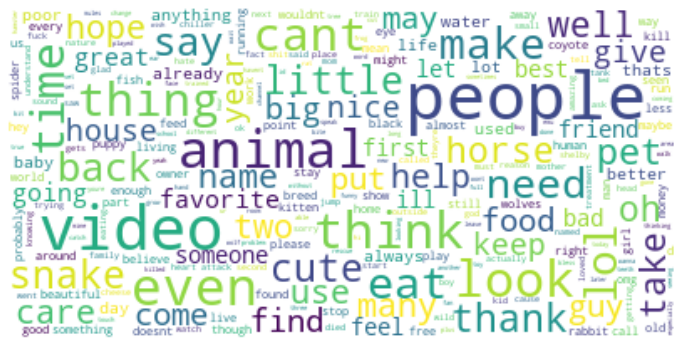

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join([(k + " ")*v for k,v in wc.items()])

wcloud = WordCloud(background_color="white", max_words=20000, collocations = False,
               contour_width=3, contour_color='steelblue',max_font_size=40)

# Generate a word cloud image
wcloud.generate(text)

# Display the generated image:
# the matplotlib way:
fig,ax0=plt.subplots(nrows=1,figsize=(12,8))
ax0.imshow(wcloud,interpolation='bilinear')

ax0.axis("off")

In [48]:
#Get all creators whenever the users label is True(cat/dog owner)
df_create = df_pets.select('creator_name').union(pred_all.filter(F.col('prediction') == 1.0).select('creator_name'))

df_create.createOrReplaceTempView("create_table")

#get count
create_count = spark.sql("select distinct creator_name, count(*) as Number\
                          from create_table \
                          group by creator_name \
                          order by Number DESC")


In [49]:
create_count.show()

+--------------------+------+
|        creator_name|Number|
+--------------------+------+
|    Brave Wilderness|    63|
|            The Dodo|    24|
|  Taylor Nicole Dean|    21|
|       Brian Barczyk|    19|
|     Gohan The Husky|    13|
|    Cole & Marmalade|    12|
|  Think Like A Horse|    12|
|Zak Georges Dog T...|    11|
|Hope For Paws - O...|    10|
|        Robin Seplut|     8|
|           Vet Ranch|     8|
|Gone to the Snow ...|     7|
|   Talking Kitty Cat|     7|
|             Steff J|     7|
|        Paws Channel|     6|
|          stacyvlogs|     6|
|            ViralHog|     6|
|     Viktor Larkhill|     5|
|    Lennon The Bunny|     4|
|           MonkeyBoo|     4|
+--------------------+------+
only showing top 20 rows



----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 53806)
Traceback (most recent call last):
  File "/opt/conda/envs/data3/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/envs/data3/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/envs/data3/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/envs/data3/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self